In [88]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [25]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))


Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

In [167]:
# Variables for pre-processing and training.
BATCH_SIZE = 16
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [168]:
# 3

# create test subdirectory
original_test_dir = 'cats_and_dogs/test'
test_subdir = os.path.join(original_test_dir, 'c_and_d')

if not os.path.exists(test_subdir):
  os.mkdir(test_subdir)

# move test images into test subdirectory so that the flow_from_directory method can find them
for filename in os.listdir(original_test_dir):
  if not '.' in filename:
    continue
  old_path_name = os.path.join(test_dir, filename)
  new_path_name = os.path.join(test_subdir, filename)
  if not os.path.exists(new_path_name):
    os.rename(old_path_name, new_path_name)

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary', batch_size=BATCH_SIZE)
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary', batch_size=BATCH_SIZE)
# Use original_test_dir to create test_data_gen to avoid overwriting the variable.
test_data_gen = test_image_generator.flow_from_directory(original_test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


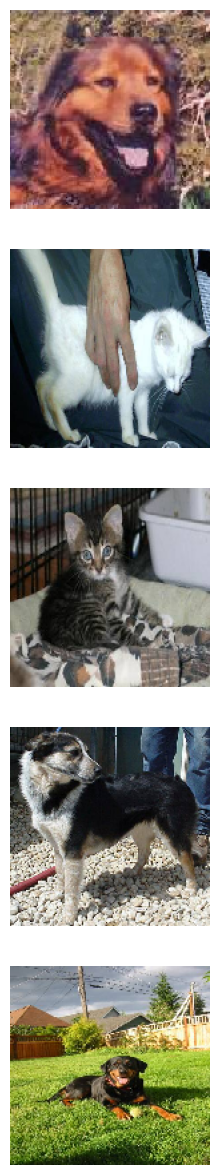

In [169]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [170]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255,          # Normalize pixel values
    rotation_range=15,          # Randomly rotate images by up to 40 degrees
    width_shift_range=0.3,      # Randomly shift images horizontally by 20%
    height_shift_range=0.3,     # Randomly shift images vertically by 20%
    shear_range=10,            # Apply random shearing transformations
    zoom_range=0.3,             # Randomly zoom into images
    horizontal_flip=True,       # Randomly flip images horizontally
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.2,
    fill_mode='nearest'         # Fill empty pixels created by transformations
)


Found 2000 images belonging to 2 classes.


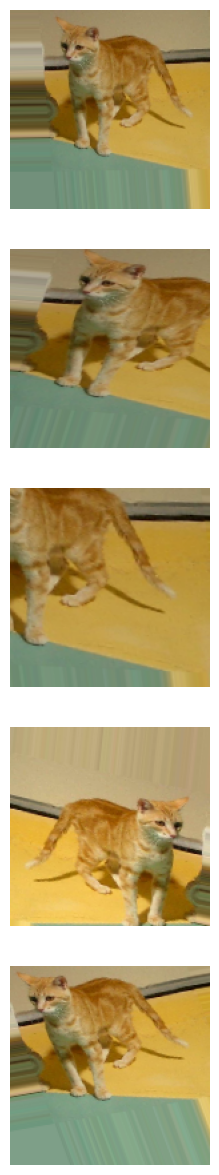

In [171]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [172]:
# 7
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Adam optimizer with learning rate of 0.001
    loss = tf.keras.losses.sparse_categorical_crossentropy,          # Binary cross-entropy for binary classification
    metrics=['accuracy']                 # Track accuracy during training
)

# Model summary for debugging
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_57 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1024)                │      37,880,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,975,105 (144.86 MB)

 Trainable params: 37,975,105 (144.86 MB)

 Non-trainable params: 0 (0.00 B)

In [173]:
# 8
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Create a validation data generator
val_data_gen = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    directory=validation_dir,  # Path to your validation data directory
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Use 'categorical' if you have more than 2 classes
)

# Load the best model from previous training session (if it exists)
try:
    model = load_model('best_model.keras')
except:
    print("No saved model found, starting fresh.")

# Define the steps per epoch and validation steps
steps_per_epoch = total_train // BATCH_SIZE
validation_steps = total_val // BATCH_SIZE

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

# Train the model
history = model.fit(
    train_data_gen,  # Training data generator
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data_gen,  # Pass the validation data generator here
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Pass the callbacks here
)


Found 1000 images belonging to 2 classes.
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 568ms/step - accuracy: 0.5065 - loss: 0.6934 - val_accuracy: 0.5010 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 564ms/step - accuracy: 0.4877 - loss: 0.6947 - val_accuracy: 0.5010 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.7003 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 578ms/step - accuracy: 0.4884 - loss: 0.6945 - val_accuracy: 0.4990 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6862 - learning_rate: 5.0000e-04
Epoch

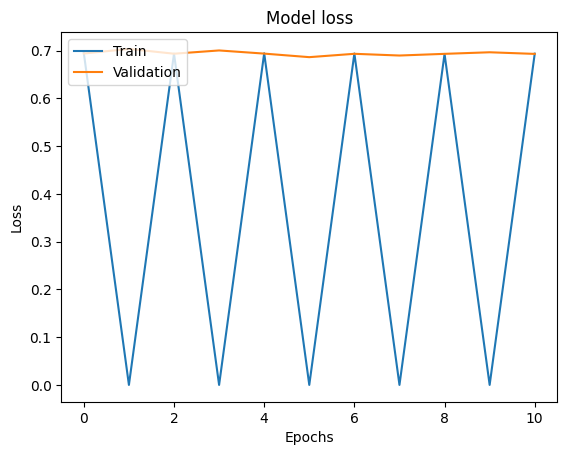

In [174]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

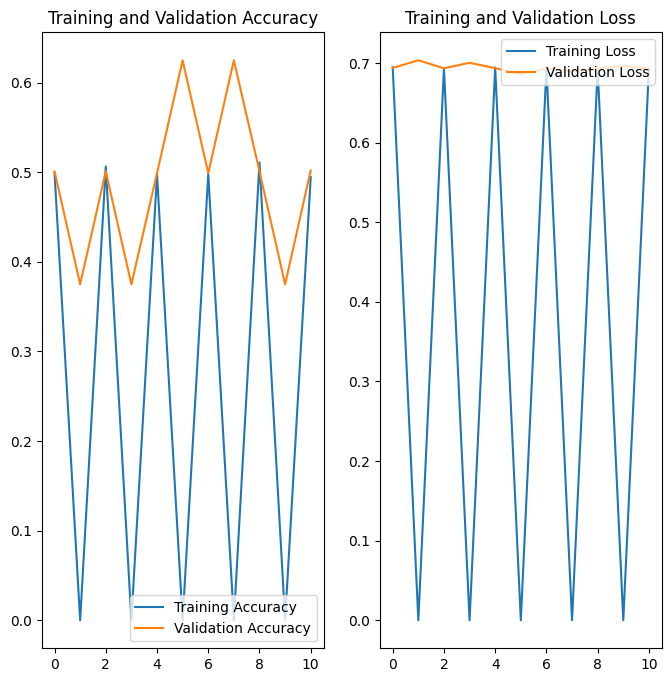

In [175]:
# Get training and validation metrics from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the minimum length of training and validation metrics
min_length = min(len(acc), len(val_acc))

# Slice all lists to match the minimum length
acc = acc[:min_length]
val_acc = val_acc[:min_length]
loss = loss[:min_length]
val_loss = val_loss[:min_length]
epochs_range = range(min_length)

# Plot training and validation accuracy/loss
plt.figure(figsize=(8, 8))

# Training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
import pandas as pd

original_test_dir = '/content/cats_and_dogs/test/c_and_d'

# List all image file paths
image_paths = [os.path.join(original_test_dir, fname) for fname in os.listdir(original_test_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Create a dataframe for the generator
test_df = pd.DataFrame({"filename": image_paths})

Found 50 validated image filenames.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


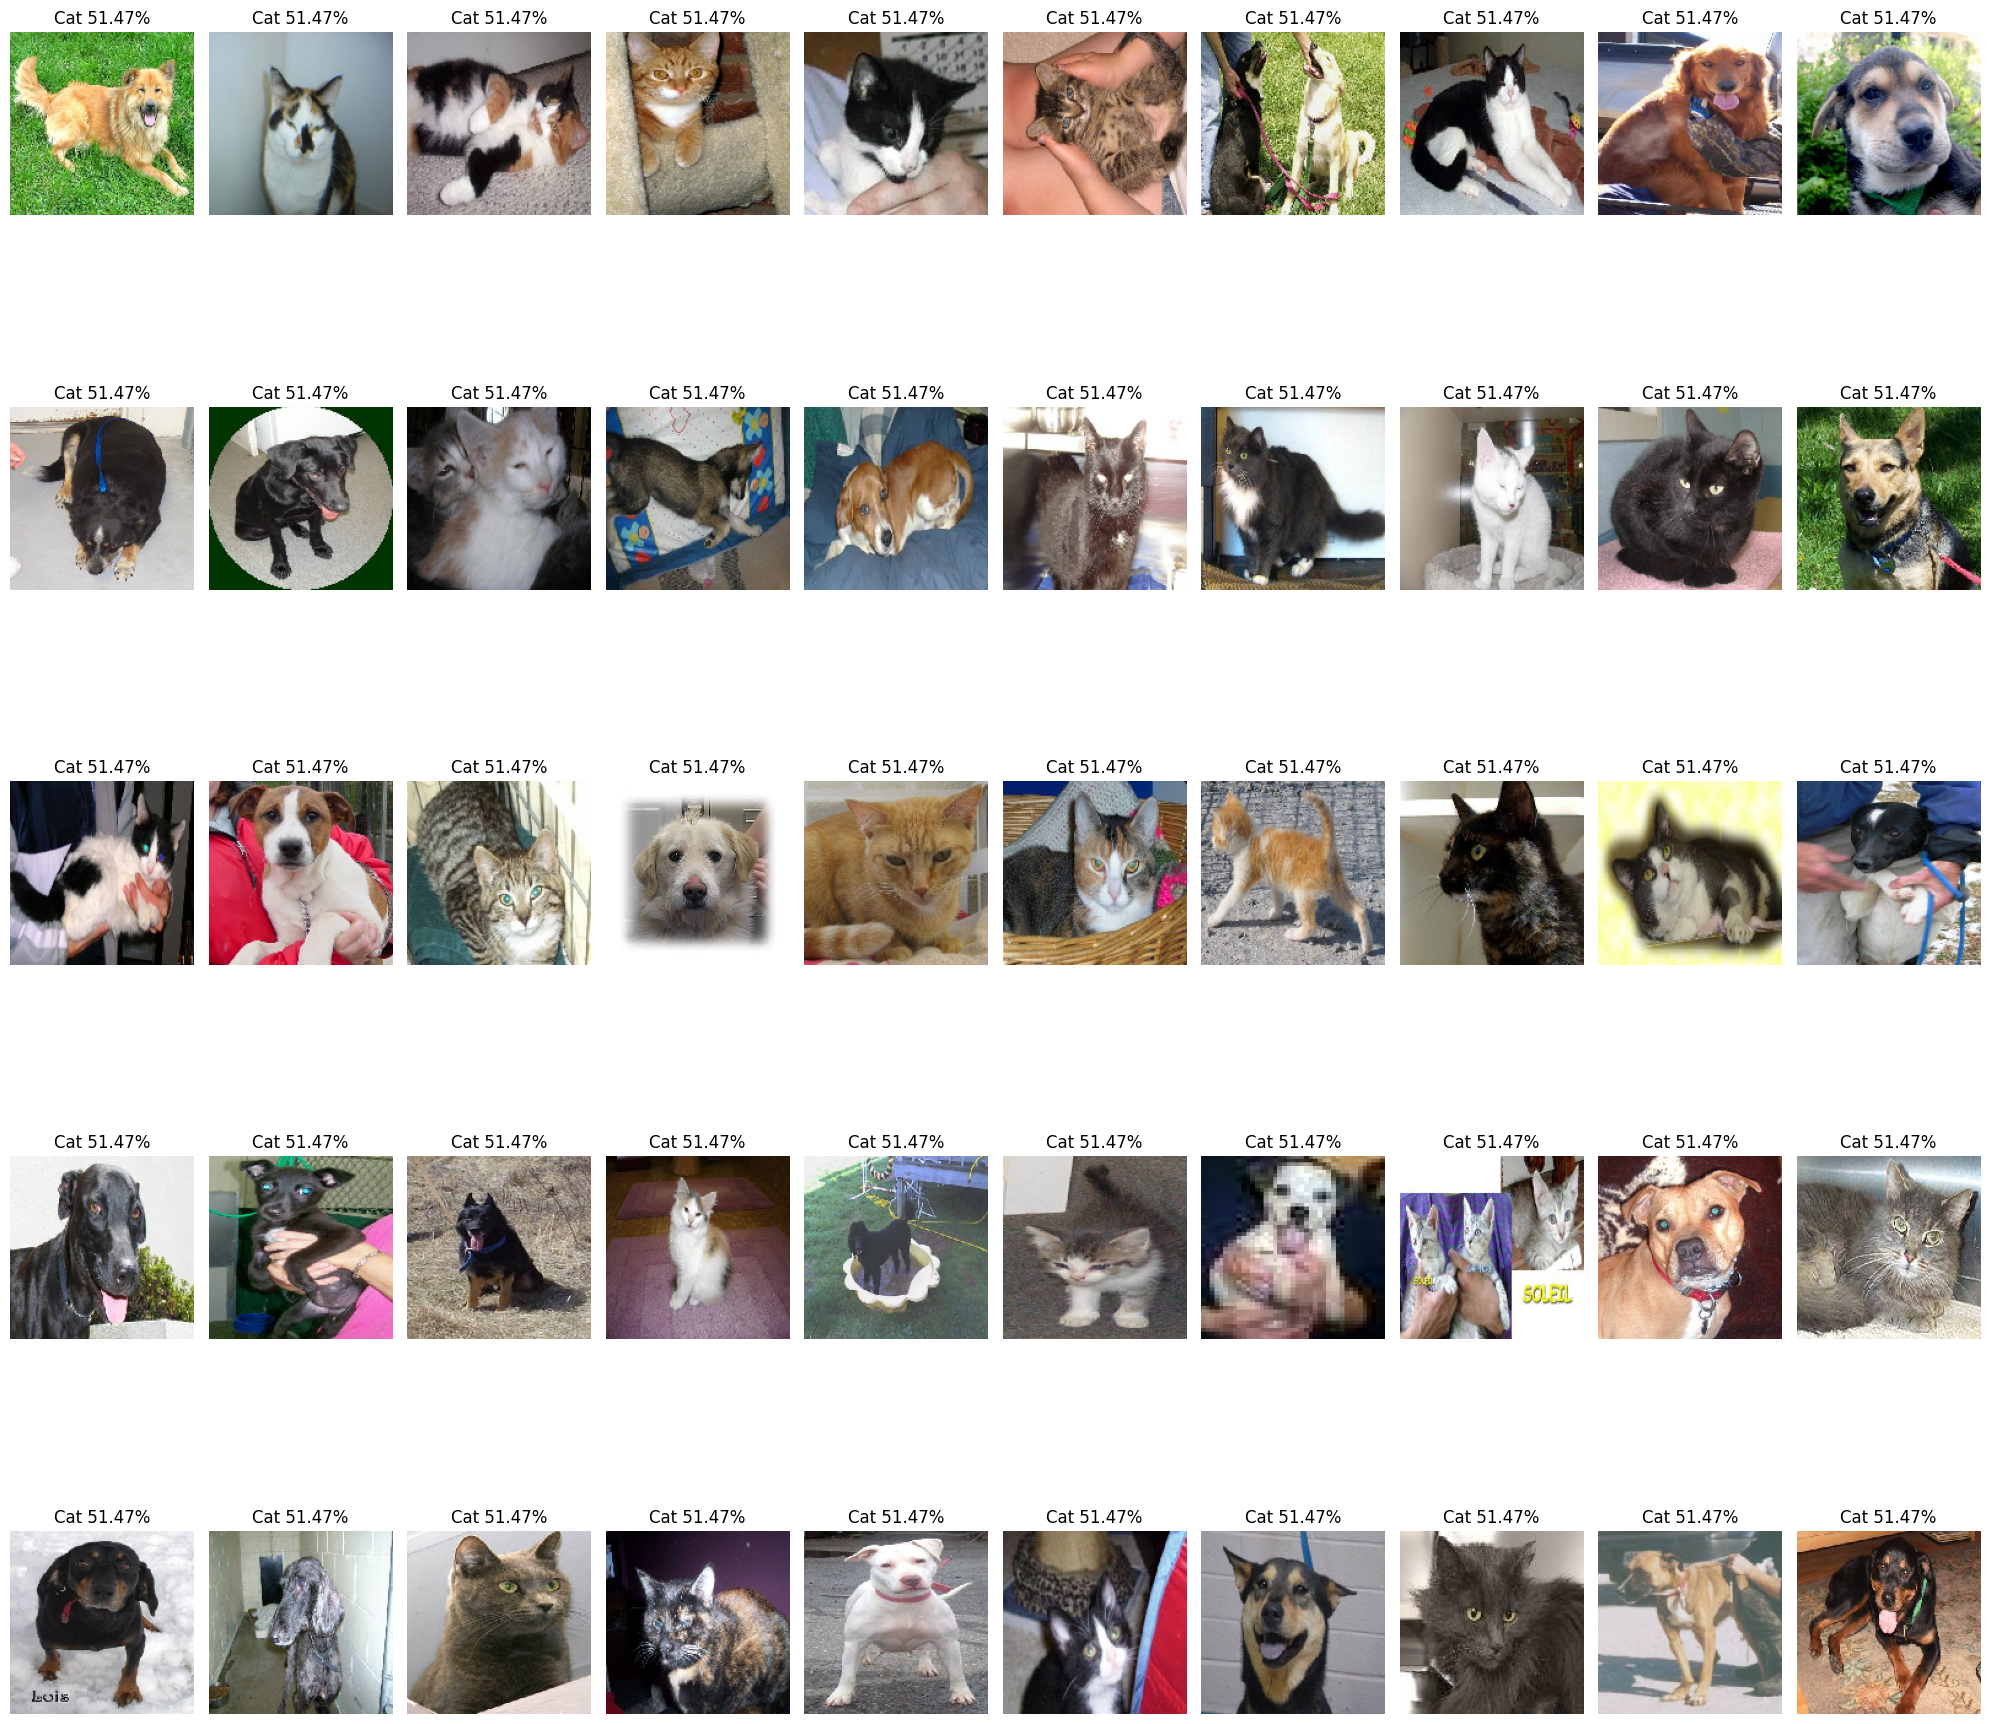

In [176]:
from tensorflow.keras.preprocessing.image import load_img # Import load_img

# Parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150

original_test_dir = '/content/cats_and_dogs/test/c_and_d'

# List all image file paths
image_paths = [os.path.join(original_test_dir, fname) for fname in os.listdir(original_test_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_paths:
    raise ValueError(f"No images found in the directory '{original_test_dir}'.")

# Create a dataframe for the generator
test_df = pd.DataFrame({"filename": image_paths})

# Create test data generator
test_data_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col=None,  # No labels
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False
)

# Predict probabilities for the test images
steps = len(test_data_gen)  # Total steps required
array_probabilities = model.predict(test_data_gen, steps=steps, verbose=1)

# Convert probabilities into a list
probabilities = [prob[0] for prob in array_probabilities]  # Assuming sigmoid activation

# Function to plot images with predictions
def plotImages(images, probabilities):
    plt.figure(figsize=(20, 20))
    for i in range(min(len(images), 50)):  # Limit to first 50 images
        plt.subplot(5, 10, i + 1)
        img_path = images[i]
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        plt.imshow(img)

        # Assign label based on probability
        label = "Dog" if probabilities[i] > 0.5 else "Cat"
        prob = probabilities[i] * 100 if probabilities[i] > 0.5 else (1 - probabilities[i]) * 100
        plt.title(f"{label} {prob:.2f}%")
        plt.axis('off')  # Turn off axis labels
    plt.tight_layout()
    plt.show()

# Call the plotImages function
plotImages(image_paths, probabilities)

In [149]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:  # Directly round probability (no index needed)
        correct += 1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 62.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
